
--- ĐANG XỬ LÝ TẬP: TRAIN ---
-> Tìm thấy 374 ảnh gốc.
-> Hoàn tất tập train:
   - Ảnh sạch: 363
   - Loại trùng lặp: 11
   - Loại nhiễu (nhãn lỗi): 0

--- ĐANG XỬ LÝ TẬP: VAL ---
-> Tìm thấy 111 ảnh gốc.
-> Hoàn tất tập val:
   - Ảnh sạch: 110
   - Loại trùng lặp: 1
   - Loại nhiễu (nhãn lỗi): 0

================= TỔNG KẾT DỮ LIỆU (CHO BÁO CÁO) =================
1. Tổng số ảnh huấn luyện (Train): 363
   - Fall (Ngã): 207
   - Not Fallen (Bình thường): 156

2. Tổng số ảnh kiểm thử (Val): 110
   - Fall (Ngã): 69
   - Not Fallen (Bình thường): 41

3. Dữ liệu sạch đã được lưu tại: Processed_Dataset


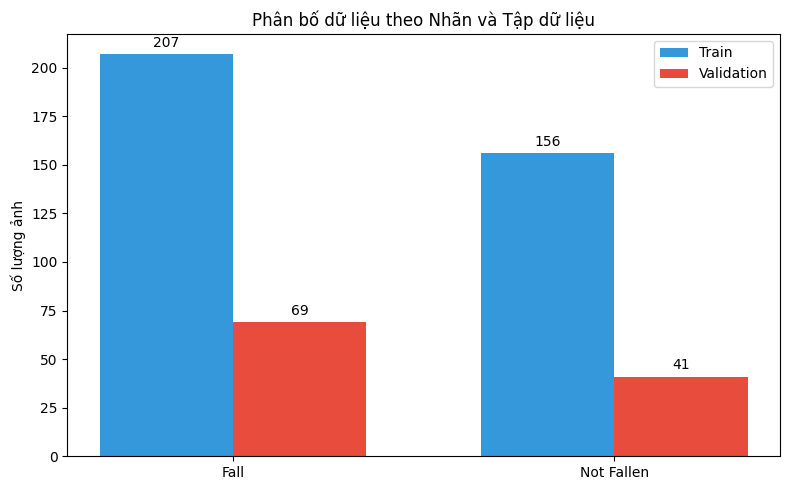

In [9]:
import os
import glob
import shutil
import cv2
import numpy as np
import imagehash
from PIL import Image
import matplotlib.pyplot as plt

# ================= CẤU HÌNH ĐƯỜNG DẪN =================
# Đường dẫn đến thư mục gốc chứa dữ liệu của bạn
ROOT_DIR = 'fall_dataset'  # <--- Đảm bảo bạn đã upload folder này lên

# Đường dẫn đầu ra (Dữ liệu sạch sẽ được lưu ở đây)
OUTPUT_DIR = 'Processed_Dataset'

# Các tham số lọc
IMG_SIZE = 640          # Resize ảnh về chuẩn YOLO
MIN_BOX_AREA = 0.005    # Loại bỏ box quá nhỏ (< 0.5% diện tích ảnh)
REMOVE_DUPLICATES = True

def process_subset(subset_name):
    """
    Hàm xử lý cho từng tập con (train hoặc val)
    """
    source_img_dir = os.path.join(ROOT_DIR, 'images', subset_name)
    source_lbl_dir = os.path.join(ROOT_DIR, 'labels', subset_name)
    
    # Tạo thư mục đầu ra tương ứng
    out_img_dir = os.path.join(OUTPUT_DIR, 'images', subset_name)
    out_lbl_dir = os.path.join(OUTPUT_DIR, 'labels', subset_name)
    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_lbl_dir, exist_ok=True)
    
    print(f"\n--- ĐANG XỬ LÝ TẬP: {subset_name.upper()} ---")
    
    # Lấy danh sách tất cả các file ảnh (jpg, png, jpeg)
    img_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
    img_paths = []
    for ext in img_extensions:
        img_paths.extend(glob.glob(os.path.join(source_img_dir, ext)))
    
    print(f"-> Tìm thấy {len(img_paths)} ảnh gốc.")
    
    hashes = {}
    stats = {
        'processed': 0,
        'duplicates': 0,
        'noise_label': 0,
        'fall_count': 0,       # Đếm dựa trên tên file
        'not_fallen_count': 0  # Đếm dựa trên tên file
    }
    
    for img_path in img_paths:
        # Lấy tên file (ví dụ: fall001.jpg -> fall001)
        filename_ext = os.path.basename(img_path)
        filename_no_ext = os.path.splitext(filename_ext)[0]
        
        # 1. Kiểm tra file nhãn tương ứng
        label_path = os.path.join(source_lbl_dir, filename_no_ext + ".txt")
        
        if not os.path.exists(label_path):
            # Nếu không có nhãn, bỏ qua
            continue

        # 2. Xử lý Trùng lặp (Duplicate Removal)
        if REMOVE_DUPLICATES:
            try:
                img_pil = Image.open(img_path)
                h = imagehash.phash(img_pil)
                if h in hashes:
                    stats['duplicates'] += 1
                    continue # Bỏ qua trùng
                hashes[h] = img_path
            except Exception as e:
                print(f"Lỗi đọc ảnh {filename_ext}: {e}")
                continue

        # 3. Xử lý Nhiễu Nhãn & Resize
        try:
            # Đọc nhãn
            with open(label_path, 'r') as f:
                lines = f.readlines()
            
            clean_lines = []
            for line in lines:
                parts = list(map(float, line.strip().split()))
                if len(parts) == 5:
                    cls, x, y, w, h = parts
                    # Kiểm tra nhiễu: Box phải nằm trong ảnh và đủ lớn
                    if 0 <= x <= 1 and 0 <= y <= 1 and w * h > MIN_BOX_AREA:
                        clean_lines.append(line)
            
            if len(clean_lines) > 0:
                # --- NẾU DỮ LIỆU HỢP LỆ THÌ LƯU ---
                
                # Đọc ảnh bằng OpenCV để resize
                img_cv = cv2.imread(img_path)
                if img_cv is None: continue
                img_resized = cv2.resize(img_cv, (IMG_SIZE, IMG_SIZE))
                
                # Lưu ảnh mới
                cv2.imwrite(os.path.join(out_img_dir, filename_ext), img_resized)
                
                # Lưu nhãn mới
                with open(os.path.join(out_lbl_dir, filename_no_ext + ".txt"), 'w') as f:
                    f.writelines(clean_lines)
                
                stats['processed'] += 1
                
                # Thống kê số lượng dựa trên tên file cho báo cáo
                if 'not fallen' in filename_no_ext.lower():
                    stats['not_fallen_count'] += 1
                elif 'fall' in filename_no_ext.lower():
                    stats['fall_count'] += 1
                    
            else:
                stats['noise_label'] += 1
                
        except Exception as e:
            print(f"Lỗi xử lý {filename_ext}: {e}")
            continue

    print(f"-> Hoàn tất tập {subset_name}:")
    print(f"   - Ảnh sạch: {stats['processed']}")
    print(f"   - Loại trùng lặp: {stats['duplicates']}")
    print(f"   - Loại nhiễu (nhãn lỗi): {stats['noise_label']}")
    
    return stats

# ================= CHẠY CHƯƠNG TRÌNH =================

# Xóa folder cũ nếu có để chạy lại từ đầu
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)

# Xử lý lần lượt folder TRAIN và VAL
train_stats = process_subset('train')
val_stats = process_subset('val')

print("\n================= TỔNG KẾT DỮ LIỆU (CHO BÁO CÁO) =================")
print(f"1. Tổng số ảnh huấn luyện (Train): {train_stats['processed']}")
print(f"   - Fall (Ngã): {train_stats['fall_count']}")
print(f"   - Not Fallen (Bình thường): {train_stats['not_fallen_count']}")

print(f"\n2. Tổng số ảnh kiểm thử (Val): {val_stats['processed']}")
print(f"   - Fall (Ngã): {val_stats['fall_count']}")
print(f"   - Not Fallen (Bình thường): {val_stats['not_fallen_count']}")

print(f"\n3. Dữ liệu sạch đã được lưu tại: {OUTPUT_DIR}")

# ================= VẼ BIỂU ĐỒ EDA =================
labels = ['Fall', 'Not Fallen']
train_counts = [train_stats['fall_count'], train_stats['not_fallen_count']]
val_counts = [val_stats['fall_count'], val_stats['not_fallen_count']]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, train_counts, width, label='Train', color='#3498db')
rects2 = ax.bar(x + width/2, val_counts, width, label='Validation', color='#e74c3c')

ax.set_ylabel('Số lượng ảnh')
ax.set_title('Phân bố dữ liệu theo Nhãn và Tập dữ liệu')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        # SỬA LỖI Ở ĐÂY: Dùng .get_height() và .get_width()
        height = rect.get_height()
        width = rect.get_width() 
        
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + width / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Gọi lại hàm vẽ biểu đồ
autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.show()
